# RAG System for Job Listings

- Practice vector database creation/adding new documents
    - Include some sort of `rank` metadata 
        - Manual/Other Resumes =  Rank 1 
        - ApplyAll = Rank 2
- Implement self-querying RAG 
    - See if can combine query transformations WITH self-querying RAG

In [44]:
from langchain.document_loaders import CSVLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma, FAISS
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
import pandas as pd
import glob, os, sys


In [3]:
import app_functions as af

In [4]:
manual_pds = glob.glob('data/Other/*.pdf')
applyall_pds = glob.glob('data/ApplyAll/*.pdf')
len(manual_pds), len(applyall_pds)

(8, 260)

In [7]:
test_pdf = manual_pds[-1] 
test_pdf

'data/Other/LinkedIn- AI & ML Engineer _ BDO USA _ LinkedIn.pdf'

In [9]:
print(af.read_pdf(test_pdf)[:1000])

AI & ML Engineer
$100K/yr - $155K/yr···Mid-Senior level
Machine Learning·Python·Show more
10,001+ employees · Accounting
1 school alum works here
Skills: Artificial Intelligence (AI), Pattern Recognition, +8 more
Apply SaveBDO USA· Columbia, MD ·1 month ago·28 applicants
HybridFull-time
Am I a good fit for this job? How can I best position myself fo
About the job
Job Description
Job Summary:
With a global network serving clients across multiple industries and countries, our
analytics game changers are poised for widespread technological impact. Our
industry-recognized team is in high demand across data analytics, robotic
process automation, and artificial intelligence. We gravitate towards bright
individuals who value impactful change, worldly purpose, and a personal
connection with diverse innovators. This role allows you to work with a team of
talented consultants, requiring you to balance innovation with pragmatic client
expectation management. With our team, you will be challenged 

In [12]:
# %pip install pypdf

In [15]:

from langchain_community.document_loaders.pdf import PyPDFLoader, PyPDFParser

loader = PyPDFLoader(
    file_path = test_pdf,#"./example_data/layout-parser-paper.pdf",
    # password = "my-pasword",
    # extract_images = True,
    # headers = None
    # extraction_mode = "plain",
    # extraction_kwargs = None,
)

pdf_docs = loader.load()
pdf_docs

[Document(page_content='AI & ML Engineer\n$100K/yr - $155K/yr···Mid-Senior level\nMachine Learning·Python·Show more\n10,001+ employees · Accounting\n1 school alum works here\nSkills: Artificial Intelligence (AI), Pattern Recognition, +8 more\nApply SaveBDO USA· Columbia, MD ·1 month ago·28 applicants\nHybridFull-time\nAm I a good fit for this job? How can I best position myself fo\nAbout the job\nJob Description\nJob Summary:\nWith a global network serving clients across multiple industries and countries, our\nanalytics game changers are poised for widespread technological impact. Our\nindustry-recognized team is in high demand across data analytics, robotic\nprocess automation, and artificial intelligence. We gravitate towards bright\nindividuals who value impactful change, worldly purpose, and a personal\nconnection with diverse innovators. This role allows you to work with a team of\ntalented consultants, requiring you to balance innovation with pragmatic client\nexpectation managem

In [18]:
pdf_docs[0].metadata

{'source': 'data/Other/LinkedIn- AI & ML Engineer _ BDO USA _ LinkedIn.pdf',
 'page': 0}

- PDF gets split into separate pages by default.
- If from LinkedIn, may contain Premium Membership insights at bottom (which we don't want)

In [33]:
from langchain_core.documents.base import Document
def load_join_annotate_pdf(pdf_fpath, metadata = {}):
    """
    Loads a PDF file, joins its content, and annotates it with metadata.
    Args:
        pdf_fpath (str): The file path to the PDF document.
        metadata (dict, optional): Additional metadata to annotate the document. Defaults to an empty dictionary.
    Returns:
        Document: A Document object containing the concatenated text of the PDF and the provided metadata.
    """
    loader = PyPDFLoader(file_path = pdf_fpath)
    pdf_docs = loader.load()
    pdf_text = " ".join([doc.page_content for doc in pdf_docs])
    
    # Return to later for cleaning up stored docs
    # split_text = pdf_text.split("Premium")
    # pdf_text = split_text[0]
    return Document(page_content = pdf_text,
                    metadata = {'file_path': pdf_fpath,
                                **metadata})

In [35]:
# Dictionary map of the sources to trust_rank
source_rank_map = {'manual':1 , 'applyall':2, 'scraped':3}

In [36]:
# Set the metadata for the document
meta_data = {'file_path': test_pdf, 'file_name': os.path.basename(test_pdf),
             'source':'manual'}
meta_data['trust_rank']=source_rank_map['manual']

# Load, join and annotate the pdf
doc = load_join_annotate_pdf(test_pdf, metadata=meta_data)
print(doc.page_content[-1000:])
print(doc.metadata)

 BDO USA | LinkedIn
https://www.linkedin.com/jobs/view/3866911336/?eBP=CwEAAAGPET5Ue5oWGLmsFkyeWdZDoeYDvLIc3hupUJ92igPK7glibsZwKciq-ZSSXOWN7Wn7IeE24… 8/9 About Accessibility Talent Solutions
Community Guidelines Careers Marketing Solutions
Ad Choices Advertising
Sales Solutions Mobile Small Business
Safety CenterQuestions?
Visit our Help Center.
Manage your account and privacy
Go to your Settings.
Recommendation transparency
Learn more about Recommended Content.Select Language
LinkedIn Corporation © 2024Learn skills to get a new job with these courses
20,722 viewers
1,890 viewers
Show more on LinkedIn Learning
ETL in Python and SQL
Learning Azure Stream Analytics
Essentials of MLOps with Azure: 2 Databricks MLflow and MLflow
Tracking
Looking for talent?Post a job
Privacy & Terms
English (English)4/24/24, 1:54 PM (28) AI & ML Engineer | BDO USA | LinkedIn
https://www.linkedin.com/jobs/view/3866911336/?eBP=CwEAAAGPET5Ue5oWGLmsFkyeWdZDoeYDvLIc3hupUJ92igPK7glibsZwKciq-ZSSXOWN7Wn7IeE24… 9/9

In [37]:
from tqdm.notebook import tqdm

In [40]:
# List to store all documents
documents =  []

# Loop to load all manual pdfs

for fpath in tqdm(manual_pds,desc='Loading manual pdfs'):
    meta_data = {'file_path': fpath, 'file_name': os.path.basename(fpath),
                 'source':'manual'}
    meta_data['trust_rank']=source_rank_map['manual']
    doc = load_join_annotate_pdf(fpath, metadata=meta_data)
    documents.append(doc)
    
for fpath in tqdm(applyall_pds,desc='Loading applyall pdfs'):
    meta_data = {'file_path': fpath, 'file_name': os.path.basename(fpath),
                 'source':'applyall'}
    meta_data['trust_rank']=source_rank_map['applyall']
    doc = load_join_annotate_pdf(fpath, metadata=meta_data)
    documents.append(doc)   


Loading manual pdfs:   0%|          | 0/8 [00:00<?, ?it/s]

Loading applyall pdfs:   0%|          | 0/260 [00:00<?, ?it/s]

In [41]:
len(documents)

268

In [ ]:
    
for fpath in tqdm(applyall_pds, desc='Loading applyall pdfs'):
    meta_data = {'file_path': fpath, 'file_name': os.path.basename(fpath),
                 'source':'applyall'}
    meta_data['trust_rank']=source_rank_map['applyall']
    doc = load_join_annotate_pdf(fpath, metadata=meta_data)
    documents.append(doc)

## Vector Database Creation

In [45]:
%pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


In [49]:
# Check # of tokens per document
# adapted from: https://github.com/openai/tiktoken/blob/main/README.md
import tiktoken
# To get the tokeniser corresponding to a specific model in the OpenAI API:
encoding = tiktoken.encoding_for_model("gpt-4o")
encoding

<Encoding 'o200k_base'>

In [50]:
# enc.encode("Hello, world!")
tokens = encoding.encode(documents[0].page_content)
num_tokens = len(tokens)
num_tokens

1563

In [52]:
def calc_num_tiktokens(doc, model_name="gpt-4o"):
    """
    Returns the number of tokens per document.
    Args:
        documents (list): A list of Document objects.
    Returns:
        list: A list of integers representing the number of tokens per document.
    """
    encoding = tiktoken.encoding_for_model(model_name)
    tokens = encoding.encode(doc.page_content)
    return len(tokens)

In [54]:
n_tokens = calc_num_tiktokens(documents[0])
n_tokens

1563

In [55]:
num_tokens = []

for doc in tqdm(documents, desc='Calculating tokens'):
    n_tokens = calc_num_tiktokens(doc)
    num_tokens.append(n_tokens)

Calculating tokens:   0%|          | 0/268 [00:00<?, ?it/s]

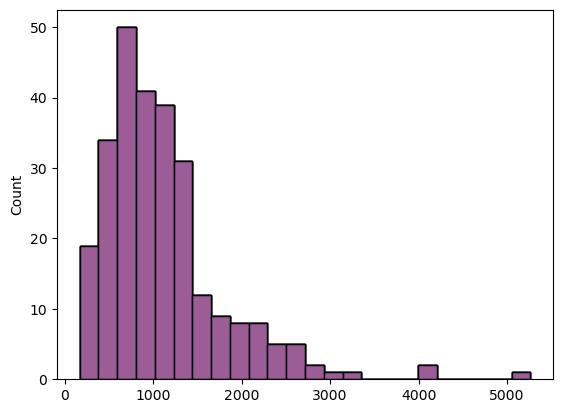

In [72]:
# Visualize the distribution of tokens
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
ax= sns.histplot(num_tokens)
fig = ax.get_figure()
fig

In [92]:

# Switch to Recursive Character Text Splitter
# text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=500,chunk_overlap=100)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000,chunk_overlap=100)
text_splitter

In [93]:
# # ## Calculating price https://openai.com/api/pricing/
# pricing = [['Model','Token Type','Price per 1000 tokens']]
# pricing.append(['gpt-4o','input tokens', 0.000250])
# pricing.append(['gpt-4o','output tokens', 0.01])
# pricing.append(['gpt-4o-mini','input tokens', 0.000150])
# pricing.append(['gpt-4o-mini','output tokens', 0.0000600])
# price_df = pd.DataFrame(pricing[1:], columns=pricing[0])
# price_df

In [76]:
# ## Calculating price https://openai.com/api/pricing/
pricing = [['Model','Input Price per 1000 tokens', 'Output Price per 1000 tokens']]
pricing.append(['gpt-4o', 0.000250, 0.01])
pricing.append(['gpt-4o-mini', 0.000150, 0.0000600])
pricing.append(['text-embedding-3-small',0.000020,pd.NA])
pricing.append(['text-embedding-ada-002',0.000100,pd.NA])
price_df = pd.DataFrame(pricing[1:], columns=pricing[0])
price_df = price_df.set_index('Model')
price_df

,Input Price per 1000 tokens,Output Price per 1000 tokens
Model,,
gpt-4o,0.00025,0.01
gpt-4o-mini,0.00015,0.00006
text-embedding-3-small,0.00002,<NA>
text-embedding-ada-002,0.00010,<NA>


In [90]:
price_df.style.background_gradient(subset=['Input Price per 1000 tokens'])

,Input Price per 1000 tokens,Output Price per 1000 tokens
Model,,
gpt-4o,0.000250,0.010000
gpt-4o-mini,0.000150,0.000060
text-embedding-3-small,0.000020,
text-embedding-ada-002,0.000100,


In [94]:
# Calculate the total number of tokens
total_tokens = np.sum(num_tokens)
total_tokens

296270

In [95]:
# Calculate the total number of tokens in thousands
thousands_of_tokens = total_tokens/ 1000
thousands_of_tokens

296.27

In [86]:
# Calculate the cost of encoding the documents with text-embedding-3-small
encoding_cost_3small = price_df.loc['text-embedding-3-small',
                             'Input Price per 1000 tokens']\
                            * thousands_of_tokens
encoding_cost_3small

0.0059254

In [88]:
# Calculate the cost of encoding the documents with text-embedding-ada-002
encoding_cost_ada = price_df.loc['text-embedding-ada-002',
                                'Input Price per 1000 tokens']\
                                * thousands_of_tokens
encoding_cost_ada

0.029627

In [98]:
# Create embedding function with cheapest model
embedding_func = OpenAIEmbeddings(model='text-embedding-3-small')
embedding_func

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x31a7d6bf0>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x31d2c8760>, model='text-embedding-3-small', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=set(), disallowed_special='all', chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None)

### Construct Vector DB

In [99]:
# Embed the documents
split_docs = text_splitter.split_documents(documents)
len(split_docs)

463

In [100]:
# Create Chroma vector store
db = Chroma.from_documents(split_docs, embedding_func, persist_directory= "data/Chroma")
# Use persist to save to disk
db.persist()

In [105]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

In [102]:
question = "What skills are required for the role of a data scientist?"
found_docs = db.as_retriever(k=3).invoke(question)
found_docs[0]

Document(page_content='outputs to the task at hand.\nMS  degree in\xa0Statistics, Ma th,\xa0Data Analytics, or a related quantitative ﬁeld\xa0\nAt\xa0least 3\xa0years of post graduate professi onal experience in Advanced Data Science, su ch as predictive modeling,\nstatistical analysi s, machine learning, text mining, geosp atial analytics, time series forecasting, optimization\xa0\nDemonstrated Experience with NLP and other components of AI\nExperience implementing AI so lutions\nExperience with one or more\xa0Advanced Data Science so ftware languages (Python,\xa0R,\xa0SAS)\xa0\xa0\nProven ability to deploy\xa0machine learning models from the research environment (Jupyter\xa0Notebooks)\xa0to\xa0production\nvia\xa0procedural\xa0or\xa0pipeline\xa0approaches\xa0\nExperience\xa0with\xa0SQL\xa0and\xa0relational databases, query authoring\xa0and tuning\xa0as well as working familiarity with a variety\nof databases\xa0including Hadoop/Hive\xa0\nExperience with sp ark and data-frames in\xa0Py

In [103]:
found_docs[0].metadata

{'file_path': 'data/ApplyAll/Blend360 AI Data Scientist - Manager _ SmartRecruiters.pdf',
 'file_name': 'Blend360 AI Data Scientist - Manager _ SmartRecruiters.pdf',
 'source': 'applyall',
 'trust_rank': 2}

In [106]:
# Construbt metadata field AttributeInfo
metadata_field_info = [
    AttributeInfo(name='source',type='string',description='Category of source type. One of manual, applyall, or scraped'),
    AttributeInfo(name='trust_rank',type='int',description='Rank of the source of the document. Lower is better.'),
    AttributeInfo(name='file_name',type='string',description='Name of the file'),
    AttributeInfo(name='file_path',type='string',description='Path to the file')
]

In [110]:
# Check how many tokens would be in k # of documents
k = 8
np.random.choice(num_tokens, k).sum()

6860

#### SelfQueryRetriever

In [111]:
# Construct the self query retriever
document_content_description = "Job listings"
# llm = ChatOpenAI(temperature=0, model='gpt-4o-mini')
retriever = SelfQueryRetriever.from_llm(
    ChatOpenAI(temperature=0, model='gpt-4o-mini'),
    db,
    document_content_description,
    metadata_field_info,
    enable_limit=True,
    search_kwargs = {'k':8}
)

#### MultiQueryRetriever

In [124]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.prompts import PromptTemplate
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)


QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

llm_query = ChatOpenAI(temperature=0, model='gpt-4o-mini')

# Run
retriever_multi = MultiQueryRetriever.from_llm(retriever=retriever, llm=llm_query, prompt=QUERY_PROMPT)
retriever_multi

MultiQueryRetriever(retriever=SelfQueryRetriever(vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x31adc12a0>, query_constructor=RunnableBinding(bound=FewShotPromptTemplate(input_variables=['query'], examples=[{'i': 1, 'data_source': '```json\n{{\n    "content": "Lyrics of a song",\n    "attributes": {{\n        "artist": {{\n            "type": "string",\n            "description": "Name of the song artist"\n        }},\n        "length": {{\n            "type": "integer",\n            "description": "Length of the song in seconds"\n        }},\n        "genre": {{\n            "type": "string",\n            "description": "The song genre, one of "pop", "rock" or "rap""\n        }}\n    }}\n}}\n```', 'user_query': 'What are songs by Taylor Swift or Katy Perry about teenage romance under 3 minutes long in the dance pop genre', 'structured_request': '```json\n{{\n    "query": "teenager love",\n    "filter": "and(or(eq(\\"artist\\", \\"Taylor Swift\\"), eq(\\"artist

In [125]:
retriever_multi.invoke("What skills are required for the role of a data scientist?")

INFO:langchain.retrievers.multi_query:Generated queries: ['What are the essential skills needed to become a data scientist?  ', 'Can you list the key competencies for a data scientist position?  ', 'What abilities should one possess to work effectively as a data scientist?  ', 'What qualifications and skills are important for a career in data science?  ', 'Which technical and soft skills are crucial for data scientists?']


[Document(page_content='outputs to the task at hand.\nMS  degree in\xa0Statistics, Ma th,\xa0Data Analytics, or a related quantitative ﬁeld\xa0\nAt\xa0least 3\xa0years of post graduate professi onal experience in Advanced Data Science, su ch as predictive modeling,\nstatistical analysi s, machine learning, text mining, geosp atial analytics, time series forecasting, optimization\xa0\nDemonstrated Experience with NLP and other components of AI\nExperience implementing AI so lutions\nExperience with one or more\xa0Advanced Data Science so ftware languages (Python,\xa0R,\xa0SAS)\xa0\xa0\nProven ability to deploy\xa0machine learning models from the research environment (Jupyter\xa0Notebooks)\xa0to\xa0production\nvia\xa0procedural\xa0or\xa0pipeline\xa0approaches\xa0\nExperience\xa0with\xa0SQL\xa0and\xa0relational databases, query authoring\xa0and tuning\xa0as well as working familiarity with a variety\nof databases\xa0including Hadoop/Hive\xa0\nExperience with sp ark and data-frames in\xa0P

### Creating the Agent

In [139]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain.schema import SystemMessage
from langchain.prompts import MessagesPlaceholder, HumanMessagePromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import AgentExecutor, create_openai_tools_agent,OpenAIFunctionsAgent


In [127]:
# Create a tool for searching reviews
tool = create_retriever_tool(
    retriever,
    "search_listings",
    "Search job listings for relevant information."
)        
tools = [tool]

In [135]:


### OLDER WAY OF CREATING PROMPT TEMPLATE - USE AS EXAMPLE
template = "You are a helpful data analyst for answering questions related to job listings. "
" If you don't know the answer, just say that you don't know, don't try to make up an answer. "
" ---------------- "
"{agent_scratchpad}\n"
    
# Generate the prompt template using the provided or default template string function
prompt_template = OpenAIFunctionsAgent.create_prompt(
    system_message=SystemMessage(template),
    extra_prompt_messages=[MessagesPlaceholder(variable_name="history")],
)

# prompt_template.get_prompts()
prompt_template.messages

[SystemMessage(content='You are a helpful data analyst for answering questions related to job listings. '),
 MessagesPlaceholder(variable_name='history'),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [138]:
# Manually construct the prompts for the agent

system_prompt = ("You are a helpful data analyst for answering questions related to job listings."
                " If you don't know the answer, just say that you don't know, don't try to make up an answer.")
prompt_messages = [SystemMessage(system_prompt),
                    MessagesPlaceholder(variable_name="history"),
                    HumanMessagePromptTemplate.from_template("{input}",),
                    MessagesPlaceholder(variable_name='agent_scratchpad')]

agent_prompt = ChatPromptTemplate.from_messages(prompt_messages)
agent_prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'history', 'input'], input_types={'history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessage(content="You are a helpful data analyst for answering questions related to job listings. If you don't know the answer, just say that you don't know, don't try to make up an answer."), MessagesPlaceholder(variable_name='history'), HumanMessagePromptTemplate(prompt=PromptTempla

In [145]:

# Initialize the language model with the specified temperature
llm = ChatOpenAI(temperature=0.0, model='gpt-4o-mini')#, api_key=os.getenv("OPENAI_API_KEY"))

# Create the agent using the language model and tools
agent = create_openai_tools_agent(llm, 
                                  tools, 
                                  agent_prompt)
# Create the agent executor with conversation buffer memory
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, memory=ConversationBufferMemory(max_length=10,return_messages=True))
agent_executor


AgentExecutor(memory=ConversationBufferMemory(return_messages=True), verbose=True, agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'history', 'input'], input_types={'history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessage(content="You are a hel

In [146]:
result = agent_executor.invoke({'input':"What skills are required for the role of a data scientist?"})
result.keys()



> Entering new AgentExecutor chain...

Invoking: `search_listings` with `{'query': 'data scientist skills required'}`


outputs to the task at hand.
MS  degree in Statistics, Ma th, Data Analytics, or a related quantitative ﬁeld 
At least 3 years of post graduate professi onal experience in Advanced Data Science, su ch as predictive modeling,
statistical analysi s, machine learning, text mining, geosp atial analytics, time series forecasting, optimization 
Demonstrated Experience with NLP and other components of AI
Experience implementing AI so lutions
Experience with one or more Advanced Data Science so ftware languages (Python, R, SAS)  
Proven ability to deploy machine learning models from the research environment (Jupyter Notebooks) to production
via procedural or pipeline approaches 
Experience with SQL and relational databases, query authoring and tuning as well as working familiarity with a variety
of databases including Hadoop/Hive 
Experience with sp ark and data-frames in P

dict_keys(['input', 'history', 'output'])

In [147]:
print(result['output'])

The skills required for the role of a data scientist typically include:

1. **Educational Background**:
   - A degree in Statistics, Mathematics, Data Analytics, Computer Science, Engineering, or a related quantitative field. Advanced degrees (M.Sc. or Ph.D.) are often desirable.

2. **Technical Skills**:
   - Proficiency in programming languages such as Python, R, or SQL.
   - Experience with machine learning frameworks and libraries (e.g., TensorFlow, PyTorch, Scikit-learn).
   - Knowledge of statistical methods and data analysis techniques.
   - Familiarity with data manipulation and analysis tools (e.g., pandas, NumPy).
   - Experience with data visualization tools and frameworks (e.g., Matplotlib, Seaborn, D3.js).
   - Understanding of big data technologies (e.g., Hadoop, Spark) and distributed computing.

3. **Machine Learning and Statistical Analysis**:
   - In-depth knowledge of machine learning methods and algorithms.
   - Experience in developing and deploying predictive mode

### Next Step: creating custom retrieval tool 
- Including trust ranks

## To Do: Add function for scraping ONET and save to Vector DB